#Import Dataset and Test (MODEL)

In order to test the data set and library imports, run this code block and confirm that the image matches its description.
For the test code, use numpy, pandas, matplotlibrary, seaborn, and sci-kit-learn.

##YOU DONT HAVE TO CHANGE THIS BLOCK OF CODE

100%|██████████| 565M/565M [00:06<00:00, 89.1MB/s]

Extracting files...


The image and the description should match here

Index: 18297
id                                             34218
gender                                           Men
masterCategory                               Apparel
subCategory                                  Topwear
articleType                                  Tshirts
baseColour                                 Off White
season                                        Summer
year                                          2013.0
usage                                         Casual
productDisplayName    Proline Off-White Polo T-shirt
Name: 18297, dtype: object


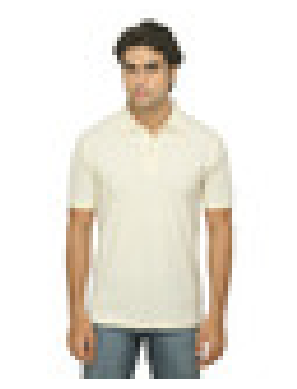

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sklearn as skl
import plotly.express as px
import spacy as sp

# Get latest version of the smaller 200ish mb data set
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

#load data with ids and indices, each id in the table corresponds to an image as well
data = pd.read_csv(path + "/styles.csv", on_bad_lines='skip')

#Test that a random item from the data set is correct
print("The image and the description should match here")
print("")
randomIndex = np.random.randint(data.shape[0])
print("Index:",randomIndex)
randomId = data.iloc[randomIndex]["id"]
randomImage = path + "/images/" + str(randomId) + ".jpg"
image = mpimg.imread(randomImage)
print(data.iloc[randomIndex])
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
articles = {}
for index, row in data.iterrows():
    article_id = row['subCategory']
    if article_id not in articles:
        articles[article_id] = []
        print(article_id)

Topwear
Bottomwear
Watches
Socks
Shoes
Belts
Flip Flops
Bags
Innerwear
Sandal
Shoe Accessories
Fragrance
Jewellery
Lips
Saree
Eyewear
Nails
Scarves
Dress
Loungewear and Nightwear
Wallets
Apparel Set
Headwear
Mufflers
Skin Care
Makeup
Free Gifts
Ties
Accessories
Skin
Beauty Accessories
Water Bottle
Eyes
Bath and Body
Gloves
Sports Accessories
Cufflinks
Sports Equipment
Stoles
Hair
Perfumes
Home Furnishing
Umbrellas
Wristbands
Vouchers


#Dimension Reduction & PreProcessing

Note that you will need to first change strings into discrete floats/numbers before you can begin your transformation of them. Also, you must run inceremental PCA due to memory restrictions. Then, we can verify whether it has worked by comparing data points visually.

In [ ]:
from sklearn.decomposition import IncrementalPCA
from scipy import stats
from sklearn.model_selection import train_test_split

def preProcess(entry):
  if pd.isna(entry):
      return 0
  elif isinstance(entry, str):
      return float('0.' + ''.join(str(ord(char)) for char in entry)) * 255
  return entry

processedData = data.drop(columns=["id","usage", "productDisplayName", "season", "year"]).map(preProcess)
train_data, test_data = train_test_split(processedData, test_size=0.2, random_state=42)
print(processedData.shape)
transformer = IncrementalPCA(n_components=2)
transformer.fit(train_data)
test_data = transformer.transform(test_data)
train_data = transformer.transform(train_data)

z_scores = np.abs(stats.zscore(test_data))
outlier_indices = np.where((z_scores > 2).any(axis=1))[0]  # Indices of rows with Z-score > 2 in any column

# Separate non-outliers and outliers
data_no_outliers = test_data[(z_scores < 2).all(axis=1)]
non_outlier_indices = np.where((z_scores < 2).all(axis=1))[0]

# Convert data to DataFrame for Plotly
plot_df = pd.DataFrame(test_data, columns=['X', 'Y'])
plot_df['Index'] = range(len(test_data))
plot_df['Type'] = ['Outlier' if i in outlier_indices else 'Non-Outlier' for i in range(len(test_data))]

# Plotting with Plotly for interactivity
fig = px.scatter(plot_df, x='Y', y='X', color='Type', hover_data={'Index': True},
                 title="Interactive 2D Plot of Test Data with Outliers Marked")
fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1)
)
# Display the interactive plot
fig.show()

(44424, 5)


43006
id                                                   18675
gender                                                 Men
masterCategory                                    Footwear
subCategory                                          Shoes
articleType                                   Sports Shoes
baseColour                                           White
season                                              Summer
year                                                2012.0
usage                                               Sports
productDisplayName    Fila Men Survivor White Sports Shoes
Name: 43006, dtype: object


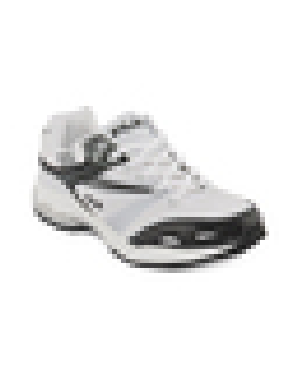

44251
id                                         25100
gender                                     Women
masterCategory                       Accessories
subCategory                                Belts
articleType                                Belts
baseColour                                   Tan
season                                    Winter
year                                      2015.0
usage                                     Casual
productDisplayName    Lino Perros Women Tan Belt
Name: 44251, dtype: object


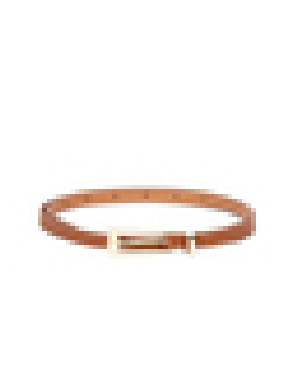

31608
id                                                               3213
gender                                                          Women
masterCategory                                               Footwear
subCategory                                                     Shoes
articleType                                              Sports Shoes
baseColour                                                      White
season                                                         Summer
year                                                           2011.0
usage                                                          Sports
productDisplayName    Nike Women Sweet Classic White Light Green Shoe
Name: 31608, dtype: object


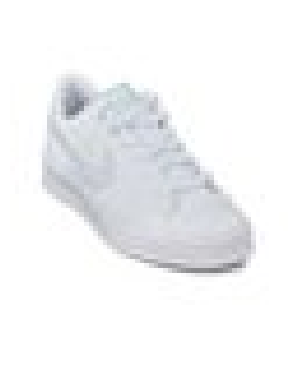

In [ ]:
targetIndices = [43006,44251,31608]
for targetIndex in targetIndices:
  randomId = data.iloc[targetIndex]["id"]
  randomImage = path + "/images/" + str(randomId) + ".jpg"
  image = mpimg.imread(randomImage)
  print(targetIndex)
  print(data.iloc[targetIndex])
  plt.imshow(image)
  plt.axis('off')
  plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# first we need to break down the labels into numerical for supervised learning model
# example for this is like masterCategory broken down into tops, bottoms, etc
data['category_encoded'] = LabelEncoder().fit_transform(data['masterCategory'])
data['baseColour_encoded'] = LabelEncoder().fit_transform(data['baseColour'])
data['articleType_encoded'] = LabelEncoder().fit_transform(data['articleType'])

# use encoded labels only
labels = data[['category_encoded', 'baseColour_encoded', 'articleType_encoded']]

# now we need to split the data for train test 20% split
train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
multi_target_model = MultiOutputClassifier(rf_model)
multi_target_model.fit(train_data, train_labels)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                       random_state=42))

In [ ]:
test_predictions = multi_target_model.predict(test_data)
category_pred = test_predictions[:, 0]
baseColour_pred = test_predictions[:, 1]
articleType_pred = test_predictions[:, 2]

# Generate the classification reports to see how accuracy is for these
print(classification_report(test_labels['category_encoded'], category_pred))
print(classification_report(test_labels['baseColour_encoded'], baseColour_pred))
print(classification_report(test_labels['articleType_encoded'], articleType_pred))

category_accuracy = accuracy_score(test_labels['category_encoded'], category_pred)
color_accuracy = accuracy_score(test_labels['baseColour_encoded'], baseColour_pred)
article_accuracy = accuracy_score(test_labels['articleType_encoded'], articleType_pred)
print(f"Accuracy for Category: {category_accuracy}")
print(f"Accuracy for Base Colour: {color_accuracy}")
print(f"Accuracy for Article Type: {article_accuracy}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2333
           1       0.99      0.99      0.99      4243
           2       0.99      1.00      0.99      1831
           3       1.00      0.79      0.88        19
           5       0.98      0.96      0.97       455
           6       1.00      0.25      0.40         4

    accuracy                           0.99      8885
   macro avg       0.99      0.83      0.87      8885
weighted avg       0.99      0.99      0.99      8885

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       135
           1       0.99      1.00      0.99      1944
           2       0.99      0.99      0.99       926
           3       0.00      0.00      0.00        17
           4       0.96      0.99      0.98       674
           5       1.00      0.58      0.74        12
           6       0.98      1.00      0.99        43
           7       1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p

### **This section is working towards trying to classify clothing given a user image **




In [ ]:
from PIL import Image, ImageEnhance
import numpy as np
import cv2  # if additional transformations are needed
from sklearn.decomposition import IncrementalPCA

In [ ]:
n_components = 2
transformer = IncrementalPCA(n_components=n_components)

In [ ]:
batch_size = 64
for i in range(0, len(train_data), batch_size):
    batch_data = train_data[i:i+batch_size]
    transformer.partial_fit(batch_data)

In [ ]:
def preprocess_image(image_path, transformer):
    # Load the image
    image = Image.open(image_path)
    image = image.resize((64, 64))  # Resize to match the model's input size

    # the best way to be able to clean this data is by using a gaussian blur
    image_cv = np.array(image)
    blur_applied = cv2.GaussianBlur(image_cv, (5, 5), 0)

    # now we can adjust the contrast and enhance it
    # this means that once we take a picture of something like a shirt
    # it is going to be more apparent
    image_pil = Image.fromarray(blur_applied)
    image_enhancer = ImageEnhance.Contrast(image_pil)
    image = image_enhancer.enhance(1.7)

    # Convert the image to a numpy array
    image_array = np.array(image) / 255.0
    flattened_data = image_array.flatten()

    if transformer:
      transformed_data = transformer.transform([flattened_data])
    else:
      transformed_data = [flattened_data]

    # data_transform = transformer.transform([flattened_data])
    return data_transform

In [ ]:
def classify_cleaned_image(image_path, model, transformer, category_label_encoder, baseColour_label_encoder, articleType_label_encoder):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path, transformer)

    # Reshape for PCA transform
    predictions = model.predict(preprocessed_image)

    # now we need to dissect the model output
    # basically by using the label encoders from training
    category = category_label_encoder.inverse_transform([predictions[0][0]])[0]
    baseColour = baseColour_label_encoder.inverse_transform([predictions[0][1]])[0]
    articleType = articleType_label_encoder.inverse_transform([predictions[0][2]])[0]

    return {
        "Category": category,
        "Base Colour": baseColour,
        "Article Type": articleType
    }

In [ ]:
# image_path = '/content/IMG_4487.jpg'
# category, baseColour, articleType = classify_cleaned_image(image_path, multi_target_model, transformer, data['category_encoded'], data['baseColour_encoded'], data['articleType_encoded'])
# print(f"Category: {category}")
# print(f"Base Colour: {baseColour}")
# print(f"Article Type: {articleType}")